#  Bài tâp về mạng tích chập

Trong bài này, chúng ta sẽ xây dựng một mạng tích chập sử dụng Torch và thử train&Test tập MNIST nhé. 


## Tổng quan một mạng CNN cơ bản

![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

## MNIST dataset

Trong bài tập này, chúng ta sẽ sử dựng tập MNIST rất nổi tiếng vể  các chữ số viết tay từ 0->9. Tập dataset này bao gồm 60000 ảnh cho training và 10000 ảnh cho testing. Các bức ảnh này đều đã được căn giữa và chỉnh với kích thước cố định là 28x28.

Trong phần tiền xử lý, chúng ta sẽ cần chuẩn hóa các giá trị pixel của mỗi ảnh về khoảng [0,1], kiểu dữ liệu sẽ là float32

<!-- ![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png) -->

Chi tiết tại: http://yann.lecun.com/exdb/mnist/

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Some configs

In [ ]:
# Số classes trong tập MNIST
num_classes = 10

# Số epoch 
epochs = 5

# Các tham số cần thiết cho quá trình traning.
learning_rate = 0.01
batch_size = 32
display_step = 9

# Tham số mạng CNN 
out_channel_1  = 16 # số channel của đầu ra conv thứ 1
out_channel_2 = 32 # số channel của đầu ra conv thứ 2

# Path lưu best model 
checkpoint = 'model.pth' # có thể để dạng *.pth

# Dataloader

In [ ]:
# Transform image 
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
    ])

# load dataset từ torchvision.datasets
train_dataset = datasets.MNIST('../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST('../data', train=False,transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size)

# Model

- Input shape sẽ là: [-1, 28, 28, 1]. Ở đây -1 sẽ thể hiện batchsize, một batch thì gồm nhiều ảnh 28x28x1 (grayscale, số channel là 1 !)
- Chúng ta sẽ định nghĩa một model đơn giản gồm 2 lớp Conv đều có filter size là 3x3 và stride hãy set là 1. 
- Ngoài ra sẽ có một lớp maxpool, set filter size 2x2
- Flow như sau: conv2d_1 -> relu -> conv2d_2 -> relu -> maxpool2d -> dropout -> flatten -> linear1 -> relu -> dropout -> linear2


In [ ]:
# Định nghĩa model 

model = nn.Sequential (
    nn.Conv2d(1, out_channel_1, kernel_size=3, stride=1),
    nn.ReLU(),
    nn.Conv2d(out_channel_1, out_channel_2, kernel_size=3, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(p=0.5),
    nn.Flatten(),
    nn.Linear(32*12*12, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10)       
)

# # load lại pretrained model (nếu có)
# try:
#   None 
# except:
#   print("!!! Hãy train để có checkpoint file")

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
best_val_loss = 999

for epoch in range(1,epochs+1):
    # Quá trình training 
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        if batch_idx % display_step == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    # Quá trình testing 
    model.eval()
    test_loss = 0
    correct = 0
    # set no grad cho quá trình testing
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            output = F.log_softmax(output) # log softmax using F
            test_loss += loss.item()
            pred = torch.argmax(output,1,keepdim=True) # argmax để lấy predicted label, chú ý keepdim = True
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset) 
    if test_loss < best_val_loss:
      best_val_loss = test_loss
      torch.save(model, checkpoint) # Lưu lại model
      print("***********    TEST_ACC = {}%    ***********".format(correct))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 0.131789
Train Epoch: 1 [288/60000 (0%)]	Train Loss: 0.189673
Train Epoch: 1 [576/60000 (1%)]	Train Loss: 0.053438
Train Epoch: 1 [864/60000 (1%)]	Train Loss: 0.405548
Train Epoch: 1 [1152/60000 (2%)]	Train Loss: 0.205838
Train Epoch: 1 [1440/60000 (2%)]	Train Loss: 0.585836
Train Epoch: 1 [1728/60000 (3%)]	Train Loss: 0.082390
Train Epoch: 1 [2016/60000 (3%)]	Train Loss: 0.618565
Train Epoch: 1 [2304/60000 (4%)]	Train Loss: 0.071584
Train Epoch: 1 [2592/60000 (4%)]	Train Loss: 0.167396
Train Epoch: 1 [2880/60000 (5%)]	Train Loss: 0.194021
Train Epoch: 1 [3168/60000 (5%)]	Train Loss: 0.037515
Train Epoch: 1 [3456/60000 (6%)]	Train Loss: 0.417827
Train Epoch: 1 [3744/60000 (6%)]	Train Loss: 0.390793
Train Epoch: 1 [4032/60000 (7%)]	Train Loss: 0.185187
Train Epoch: 1 [4320/60000 (7%)]	Train Loss: 0.227709
Train Epoch: 1 [4608/60000 (8%)]	Train Loss: 0.210564
Train Epoch: 1 [4896/60000 (8%)]	Train Loss: 0.156789
Train Epoch: 1 [5184/60000 (9%)]	T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


***********    TEST_ACC = 9507%    ***********
Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.378041
Train Epoch: 2 [288/60000 (0%)]	Train Loss: 0.373799
Train Epoch: 2 [576/60000 (1%)]	Train Loss: 0.210683
Train Epoch: 2 [864/60000 (1%)]	Train Loss: 0.376090
Train Epoch: 2 [1152/60000 (2%)]	Train Loss: 0.110360
Train Epoch: 2 [1440/60000 (2%)]	Train Loss: 0.352285
Train Epoch: 2 [1728/60000 (3%)]	Train Loss: 0.382201
Train Epoch: 2 [2016/60000 (3%)]	Train Loss: 0.164759
Train Epoch: 2 [2304/60000 (4%)]	Train Loss: 0.037516
Train Epoch: 2 [2592/60000 (4%)]	Train Loss: 0.202768
Train Epoch: 2 [2880/60000 (5%)]	Train Loss: 0.082261
Train Epoch: 2 [3168/60000 (5%)]	Train Loss: 0.101049
Train Epoch: 2 [3456/60000 (6%)]	Train Loss: 0.078787
Train Epoch: 2 [3744/60000 (6%)]	Train Loss: 0.464834
Train Epoch: 2 [4032/60000 (7%)]	Train Loss: 0.121584
Train Epoch: 2 [4320/60000 (7%)]	Train Loss: 0.183435
Train Epoch: 2 [4608/60000 (8%)]	Train Loss: 0.305175
Train Epoch: 2 [4896/60000 (8%)]	Train Lo

# Visualize Image

In [55]:
# load lại model đã train
model= torch.load(checkpoint)
# set eval phase 
model.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.5, inplace=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4608, out_features=128, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=128, out_features=10, bias=True)
)

In [56]:
item = iter(test_loader)

In [57]:
data,target = item.next() # lấy một batch ra

In [58]:
test_idx = random.choice(range(len(data))) # lấy index của một phần tử của một batch

In [59]:
data = data[test_idx]
target = target[test_idx]
assert data.shape == (1,28,28)

In [60]:
# thử predict 

def plot(data,model):
  data = torch.unsqueeze(data,0) # unsqueeze data
  output = model(data)
  output = F.log_softmax(output) # log softmax, chú ý dim
  pred = torch.argmax(output,1,keepdim=True) # argmax, chú ý keepdim 
  print("Predict Number : ", pred[0][0].numpy()) 
  plt.imshow(data[0][0],cmap='gray')
  plt.show()

Predict Number :  2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


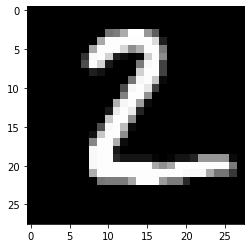

In [61]:
plot(data,model)